### Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install rdkit
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Concatenate

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')

[]

In [ ]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', None)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*italicized text*### Load the dataset from the original publication

In [6]:
DF_MRI = pd.read_excel(open('drive/My Drive/Copolymer-main/Copolymer-main/datasets/Dataset 2.xlsx', 'rb'),
                       sheet_name='Data organized fluoro-monomer')

In [7]:
DF_MRI

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.00,0.00,0.10,0.90,0.00,0.00,20,0.036740,-,-
1,0.00,0.00,0.20,0.30,0.00,0.50,47,0.117168,7100,1.25
2,0.00,0.00,0.20,0.30,0.50,0.00,61,0.127174,8100,1.16
3,0.00,0.00,0.20,0.40,0.00,0.40,46,0.105659,7800,1.26
4,0.00,0.00,0.20,0.40,0.40,0.00,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
413,0.65,0.00,0.00,0.15,0.15,0.05,X,0.187427,-,-
414,0.70,0.00,0.00,0.30,0.00,0.00,55,0.158419,-,-
415,0.75,0.00,0.00,0.00,0.05,0.20,X,0.277993,-,-
416,0.80,0.00,0.00,0.10,0.00,0.10,X,0.243231,-,-


### Construct the summary table

In [8]:
TFEA = 'C(OC(=O)C(C[*])[*])C(F)(F)F'
HexaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
NonaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
PEGA = 'O(C(=O)C(C[*])[*])CCOC'
HEA = 'O(C(=O)C(C[*])[*])CCO[H]'
MSEA = 'O(C(=O)C(C[*])[*])CC[S](C)=O'

In [9]:
Flag = [i !='X' for i in DF_MRI['19F NMR Signal-to-Noise Ratioa']]

In [10]:
DF_MRI[Flag]

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-


In [11]:
Dataset_2 = DF_MRI[Flag].copy()

In [12]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
  smi = 'C'
  if Dataset_2['TFEA'].iloc[i] > 0:
    smi += '.C(OC(=O)C(C[*])[*])C(F)(F)F'
  if Dataset_2['HexaFOEA'].iloc[i] >0:
    smi += '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
  if Dataset_2['NonaFOEA'].iloc[i] >0:
    smi += '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
  if Dataset_2['PEGA'].iloc[i] >0:
    smi += '.O(C(=O)C(C[*])[*])CCOC'
  if Dataset_2['HEA'].iloc[i] >0:
    smi += '.O(C(=O)C(C[*])[*])CCO[H]'
  if Dataset_2['MSEA'].iloc[i] >0:
    smi += '.O(C(=O)C(C[*])[*])CC[S](C)=O'
  Dataset_2['Smiles'].iloc[i] = smi

In [13]:
Dataset_2

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b,Smiles
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
...,...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...


#Feature Engineering with Morgan Fingerprint

In [14]:
MOL = pd.DataFrame(['C(OC(=O)C(C[*])[*])C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC',
'O(C(=O)C(C[*])[*])CCO[H]',
'O(C(=O)C(C[*])[*])CC[S](C)=O'])[0].apply(Chem.MolFromSmiles)

In [15]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [16]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
  for j in i.keys():
    HashCode.append(j)
  unique_set = set(HashCode)
  unique_list = list(unique_set)

  Corr_df = pd.DataFrame(unique_list).reset_index()


In [17]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
  my_finger = [0] * len(unique_list)
  for key in polymer.keys():
    index = Corr_df[Corr_df[0] == key]['index'].values[0]
    my_finger[index] = polymer[key]
  MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)

In [18]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,2,0,1,1,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2
2,1,0,0,0,2,0,0,1,3,1,...,1,1,1,1,0,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
5,1,1,0,0,1,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [19]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

80


In [20]:
X

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,2,0,1,1,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2
2,1,0,0,0,2,0,0,1,3,1,...,1,1,1,1,0,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
5,1,1,0,0,1,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


#CNN

Stack feature vectors into a feature matrix based on the sequential distribution of the copolymer

In [21]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
  random.seed(10)

  Random_position = []
  Random_position_all = []

  Rest = range(0,100)
  for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:
    X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
    Random_position.append(X_random_position)
    for p in X_random_position:
      Random_position_all.append(p)
    Rest = []
    for x in range(0,100):
      if x not in Random_position_all:
        Rest.append(x)

  Sequency_X = [0 for a in range(100)]
  for j in range(100):
    if j in Random_position[0]:
      Sequency_X[j] = list(X.iloc[0].values)
    elif j in Random_position[1]:
      Sequency_X[j] = list(X.iloc[1].values)
    elif j in Random_position[2]:
      Sequency_X[j] = list(X.iloc[2].values)
    elif j in Random_position[3]:
      Sequency_X[j] = list(X.iloc[3].values)
    elif j in Random_position[4]:
      Sequency_X[j] = list(X.iloc[4].values)
    elif j in Random_position[5]:
      Sequency_X[j] = list(X.iloc[5].values)

  Mix_X_100Block.append(Sequency_X)

Mix_X_100Block = np.array(Mix_X_100Block)

In [22]:
Mix_X_100Block.shape

(271, 100, 80)

In [23]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

Reshape the size of the feature matrix to be suitable for the CNN architecture

Note: There are 271 copolymers. The feature vector for one monomer has a length of 80, and
100 feature vectors are stacked to represent a copolymer. The number of each monomer is set
in the same proportion as their composition in the copolymer, e.g., stacking 55 FA and 45 FB if
the molar ration of the copolymer A:B is 55:45. Finally the size of the input matrix is
271 * 100 * 80, as shown in Figure 5

In [24]:
Mix_X_100Block = Mix_X_100Block.reshape((271,100,80,1))
Mix_X_100Block.shape

(271, 100, 80, 1)

Build CNN model using the TensorFlow package and train the model on the copolymer dataset.
a. Employ Keras RandomSearch to optimize hyperparameters such as the number of layers, the
number of neurons in each layer, and the learning rate.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=42)

In [26]:
model = Sequential()
model.add(Conv2D(8,(10,10), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(8, (4,4), activation='relu'))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1))
optimizer=keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model = model.fit(x=X_train, y=y_train, epochs=50,
                  batch_size=64, validation_split=0.2)

Epoch 1/50
3/3 [==============================] - 6s 1s/step - loss: 50.1577 - val_loss: 15.0958
Epoch 2/50
3/3 [==============================] - 2s 801ms/step - loss: 17.5328 - val_loss: 14.7737
Epoch 3/50
3/3 [==============================] - 2s 758ms/step - loss: 17.3215 - val_loss: 14.5021
Epoch 4/50
3/3 [==============================] - 2s 781ms/step - loss: 17.4756 - val_loss: 14.3433
Epoch 5/50
3/3 [==============================] - 2s 788ms/step - loss: 16.4847 - val_loss: 14.2825
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 14.6035 - val_loss: 13.8672
Epoch 7/50
3/3 [==============================] - 2s 775ms/step - loss: 15.0113 - val_loss: 16.0341
Epoch 8/50
3/3 [==============================] - 2s 779ms/step - loss: 14.2074 - val_loss: 13.5088
Epoch 9/50
3/3 [==============================] - 2s 792ms/step - loss: 13.8560 - val_loss: 15.3820
Epoch 10/50
3/3 [==============================] - 2s 751ms/step - loss: 13.5362 - val_loss: 12.6031
Epoch

Output the training R2
, MAE, and RMSE as well as the test R2
, MAE, and RMSE after the
training is completed.

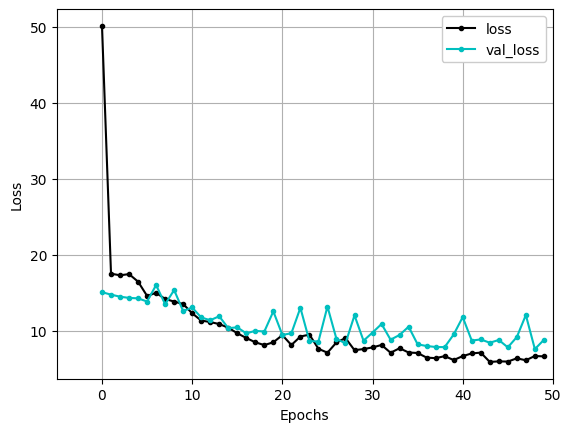

In [27]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs= len(loss)
plt.xlim((-5,50))
plt.plot(range(epochs), loss, color = 'k', marker='.', label='loss')
plt.plot(range(epochs), val_loss, color= 'c', marker= '.', label='val_loss')
#plt.xticks(fontname='Arial', fontsize=16, fontweight='normal')
#plt.yticks(fontname='Arial', fontsize=16, fontweight='normal')
plt.legend(loc= 'best', framealpha=1)#, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs')#, fontname='Arial', fontsize=16 )
plt.ylabel('Loss')#, fontname='Arial', fontsize=16 )
plt.savefig('CNN_Loss.pdf', dpi=600, bbox_inches='tight')

In [28]:
filepath = 'MRI_CNN.model'
save_model(model, filepath, save_format='h5')

In [29]:
model = load_model('MRI_CNN.model')

In [30]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Train set R^2: %.2f' % r2_score(y_train, y_pred_train))
print('Train MAE score: %.2f' % mean_absolute_error(y_train, y_pred_train))
print('Train RMSE score: %.2f' %np.sqrt(mean_absolute_error(y_train, y_pred_train)))

print('Test set R^2: %.2f' % r2_score(y_test, y_pred_test))
print('Test MAE score: %.2f' % mean_absolute_error(y_test, y_pred_test))
print('Test RMSE score: %.2f' %np.sqrt(mean_absolute_error(y_test, y_pred_test)))

2/2 [==============================] - 0s 64ms/step
Train set R^2: 0.74
Train MAE score: 9.48
Train RMSE score: 3.08
Test set R^2: 0.65
Test MAE score: 11.37
Test RMSE score: 3.37


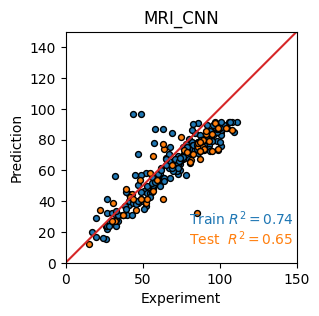

In [33]:
plt.figure(figsize=(3,3))

ax = plt.subplot(1,1,1)
plt.scatter(y_train, y_pred_train, c = '#1f77b4', marker='o', s=18, edgecolors='k')
plt.scatter(y_test, y_pred_test, c = '#ff7f0e', marker='o', s=18, edgecolors='k')

plt.xlabel('Experiment')
plt.ylabel('Prediction')
x0,x1 = min(y_train), max(y_train)
length = 750
x_start , x_end = -200, 550
plt.xlim([-0,150])
plt.ylim([-0,150])
#plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect('equal', adjustable='box')
#theunit line
plt.plot(np.arange(x_start, x_end, 0.01*length) ,
         np.arange(x_start, x_end, 0.01*length), '#d62728' )
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2))
,{'color':'#1f77b4'})
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test))
,{'color':'#ff7f0e'})
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_CNN')#,fontname="Times New Roman", fontsize=10)
plt.savefig("drive/My Drive/Copolymer-main/Copolymer-main/Polyinfo_MRI_CNN.pdf",
            dpi=1200, bbox_inches='tight')



#Data Fusion

In [ ]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [ ]:
Mix_X.shape

(271, 80)

In [ ]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)

        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = 0
            elif j in Random_position[1]:
                Sequency_X[j] = 1
            elif j in Random_position[2]:
                Sequency_X[j] = 2
            elif j in Random_position[3]:
                Sequency_X[j] = 3
            elif j in Random_position[4]:
                Sequency_X[j] = 4
            elif j in Random_position[5]:
                Sequency_X[j] = 5

        Mix_X_100Block.append(Sequency_X)

Mix_X_100Block = np.array(Mix_X_100Block)

In [ ]:
Mix_X_100Block.shape

(271, 100)

In [ ]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 1))
Mix_X_100Block.shape

(271, 100, 1)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Concatenate
import tensorflow

In [ ]:
LSTMunits = 20

In [ ]:
# define two sets of inputs
inputA = Input(shape=(100,1))
inputB = Input(shape=(80))
# the first branch operates on the first input

RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))

# the second branch opreates on the second input
y = Dense(8, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = Concatenate()([RNNmodel.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[RNNmodel.input, y.input], outputs=z)


xtrain_B, xtest_B, ytrain_B, ytest_B=train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)
xtrain_A, xtest_A, ytrain_A, ytest_A=train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

Model = model.fit(
    x=[xtrain_A, xtrain_B], y=ytrain_B,
    validation_data=([xtest_A, xtest_B], ytest_B),
    epochs=300, batch_size=32, verbose=2) #epochs=100, batch_size=128, verbose=2)

Epoch 1/300
7/7 - 12s - loss: 5250.3867 - mean_squared_error: 5250.3867 - val_loss: 5865.6548 - val_mean_squared_error: 5865.6548 - 12s/epoch - 2s/step
Epoch 2/300
7/7 - 1s - loss: 5202.3599 - mean_squared_error: 5202.3599 - val_loss: 5788.7002 - val_mean_squared_error: 5788.7002 - 923ms/epoch - 132ms/step
Epoch 3/300
7/7 - 1s - loss: 5097.3931 - mean_squared_error: 5097.3931 - val_loss: 5620.8340 - val_mean_squared_error: 5620.8340 - 854ms/epoch - 122ms/step
Epoch 4/300
7/7 - 1s - loss: 4892.4375 - mean_squared_error: 4892.4375 - val_loss: 5327.8848 - val_mean_squared_error: 5327.8848 - 972ms/epoch - 139ms/step
Epoch 5/300
7/7 - 1s - loss: 4555.2529 - mean_squared_error: 4555.2529 - val_loss: 4865.7212 - val_mean_squared_error: 4865.7212 - 1s/epoch - 172ms/step
Epoch 6/300
7/7 - 2s - loss: 4035.0891 - mean_squared_error: 4035.0891 - val_loss: 4203.5674 - val_mean_squared_error: 4203.5674 - 2s/epoch - 226ms/step
Epoch 7/300
7/7 - 2s - loss: 3337.7722 - mean_squared_error: 3337.7722 - v

In [ ]:
with open('Fusion_Loss.pickle', 'wb') as handle:
  pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open('Fusion_Loss.pickle', 'rb'))

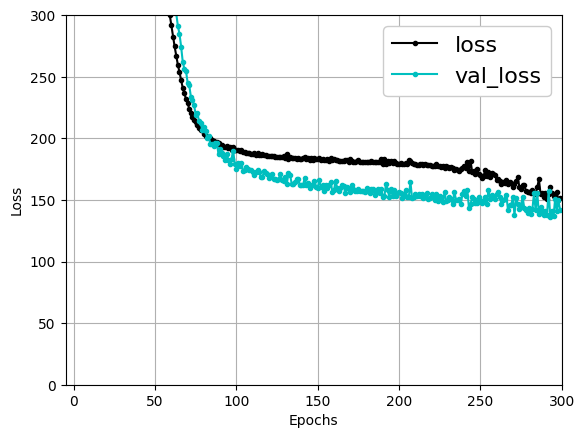

In [ ]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5,300))
plt.ylim((0,300))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Fusion_loss.svg', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
filepath = 'MRI_FusionModel.model'
save_model(model, filepath, save_format='h5')

In [ ]:
model = load_model('MRI_FusionModel.model')

In [ ]:
y_train = ytrain_B
y_test = ytest_B

y_pred_train = model.predict([xtrain_A, xtrain_B])
print('Train set R^2: ', r2_score(y_train, y_pred_train))

y_pred_test = model.predict([xtest_A, xtest_B])
print('Test set R^2: ', r2_score(y_test, y_pred_test))

7/7 [==============================] - 2s 26ms/step
Train set R^2:  0.7037743098690679
2/2 [==============================] - 0s 25ms/step
Test set R^2:  0.7675930521379837


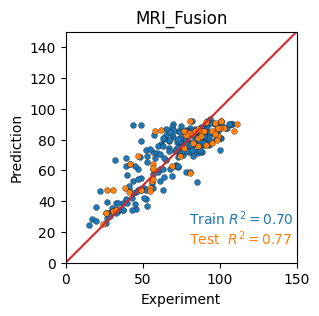

In [ ]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2)

plt.xlabel("Experiment")#,fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction")#,fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
#plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_Fusion')#,fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_FusionModel.pdf", dpi=1200, bbox_inches='tight')

#FFNN

Prepare the input for the training of the FFNN model.
a. Calculate the feature vector of a copolymer FAB as the molar-weighted summation of each
monomer’s feature vector: FAB = FAmA + FBmB:

In [ ]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [ ]:
Mix_X.shape

(271, 80)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [ ]:
model = keras.models.Sequential()
model.add(Dense(units = 24, input_dim = x_train.shape[1], activation='relu'))
model.add(Dense(units = 64,  activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
Model = model.fit(x_train, y_train, epochs=1000, batch_size=128,
                  validation_data = (x_test, y_test), verbose=2)


Epoch 1/1000
2/2 - 1s - loss: 5128.2793 - mean_squared_error: 5128.2793 - val_loss: 6153.4141 - val_mean_squared_error: 6153.4141 - 830ms/epoch - 415ms/step
Epoch 2/1000
2/2 - 0s - loss: 5091.6055 - mean_squared_error: 5091.6055 - val_loss: 6114.5186 - val_mean_squared_error: 6114.5186 - 37ms/epoch - 19ms/step
Epoch 3/1000
2/2 - 0s - loss: 5057.8887 - mean_squared_error: 5057.8887 - val_loss: 6077.5205 - val_mean_squared_error: 6077.5205 - 35ms/epoch - 17ms/step
Epoch 4/1000
2/2 - 0s - loss: 5026.0571 - mean_squared_error: 5026.0571 - val_loss: 6041.0938 - val_mean_squared_error: 6041.0938 - 34ms/epoch - 17ms/step
Epoch 5/1000
2/2 - 0s - loss: 4994.2417 - mean_squared_error: 4994.2417 - val_loss: 6004.0767 - val_mean_squared_error: 6004.0767 - 37ms/epoch - 18ms/step
Epoch 6/1000
2/2 - 0s - loss: 4961.8687 - mean_squared_error: 4961.8687 - val_loss: 5966.0103 - val_mean_squared_error: 5966.0103 - 54ms/epoch - 27ms/step
Epoch 7/1000
2/2 - 0s - loss: 4928.4902 - mean_squared_error: 4928.4

In [ ]:
with open('FFNN_Loss.pickle', 'wb') as handle:
  pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open("FFNN_Loss.pickle","rb"))

<function matplotlib.pyplot.show(close=None, block=None)>

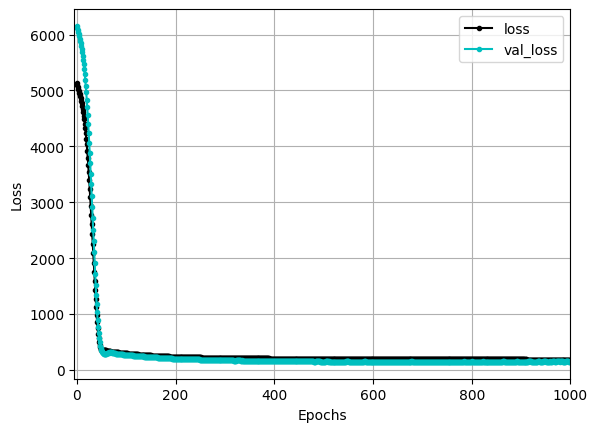

In [ ]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim(-5, 1000)
plt.plot(range(epochs), loss, color='k', marker='.', label='loss')
plt.plot(range(epochs), val_loss, color='c', marker='.', label='val_loss')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig("FFNN_Loss.pdf", dpi=600, bbox_inches='tight')
plt.show

In [ ]:
filepath = 'MRI_DNN.model'
save_model(model, filepath, save_format='h5')

In [ ]:
model = load_model('MRI_DNN.model')

In [ ]:
y_pred_train = model.predict(x_train)
print('Train set R^2: %.2f' % r2_score(y_train, y_pred_train ))
print('Train MAE score: %.2f' % mean_absolute_error(y_train, y_pred_train ))
print('Train RMSE score: %.2f' % np.sqrt(mean_absolute_error(y_train, y_pred_train )))

y_pred_test = model.predict(x_test)
print('Test set R^2: %.2f' % r2_score(y_test, y_pred_test ))
print('Test MAE score: %.2f' % mean_absolute_error(y_test, y_pred_test ))
print('Test RMSE: %.2f' % np.sqrt(mean_absolute_error(y_test, y_pred_test )))


7/7 [==============================] - 0s 3ms/step
Train set R^2: 0.64
Train MAE score: 10.67
Train RMSE score: 3.27
2/2 [==============================] - 0s 5ms/step
Test set R^2: 0.71
Test MAE score: 10.47
Test RMSE: 3.24


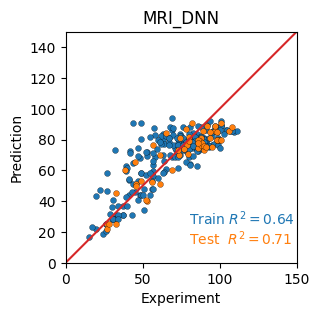

In [ ]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2)

plt.xlabel("Experiment")#,fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction")#,fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
#plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_DNN')#,fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_DNN.pdf", dpi=1200, bbox_inches='tight')

#RNN

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score


In [ ]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)

        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)

        Mix_X_100Block.append(Sequency_X)

Mix_X_100Block = np.array(Mix_X_100Block)

In [ ]:
Mix_X_100Block.shape

(271, 100, 80)

In [ ]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [ ]:
def getRNNmodel(LSTMunits):

  RNNmodel = Sequential()
  RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,80)))
  RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
  RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation='relu')))
  RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
  RNNmodel.add(Dense(1))

  return RNNmodel

LSTMunits =20
RNNmodel = getRNNmodel(LSTMunits)
RNNmodel.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
Model = RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=64)

Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 5315.6704 - mean_squared_error: 5315.6704 - val_loss: 4458.6626 - val_mean_squared_error: 4458.6626
Epoch 2/200
3/3 [==============================] - 1s 183ms/step - loss: 5205.0781 - mean_squared_error: 5205.0786 - val_loss: 4292.9282 - val_mean_squared_error: 4292.9282
Epoch 3/200
3/3 [==============================] - 1s 177ms/step - loss: 4985.3755 - mean_squared_error: 4985.3755 - val_loss: 4035.9436 - val_mean_squared_error: 4035.9436
Epoch 4/200
3/3 [==============================] - 1s 196ms/step - loss: 4675.4956 - mean_squared_error: 4675.4956 - val_loss: 3704.9709 - val_mean_squared_error: 3704.9709
Epoch 5/200
3/3 [==============================] - 1s 266ms/step - loss: 4279.9624 - mean_squared_error: 4279.9624 - val_loss: 3301.9666 - val_mean_squared_error: 3301.9666
Epoch 6/200
3/3 [==============================] - 1s 346ms/step - loss: 3788.5083 - mean_squared_error: 3788.5083 - val_loss: 2821.2332 

In [ ]:
with open('RNN_loss.pickle', 'wb') as handle:
  pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open('RNN_loss.pickle', 'rb'))

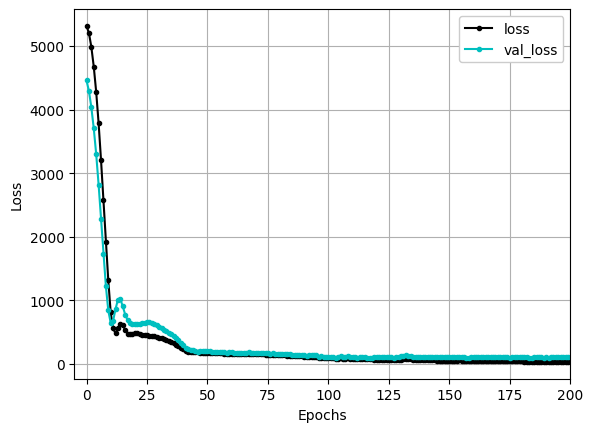

In [ ]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 200))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
#plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
#plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1)#, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs')#,fontname="Arial", fontsize=16)
plt.ylabel('Loss')#,fontname="Arial", fontsize=16)
plt.savefig("RNN_Loss.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
filepath = 'MRI_RNN.model'
save_model(RNNmodel, filepath, save_format='h5')

In [ ]:
RNNmodel = load_model('MRI_RNN.model')

In [ ]:
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

7/7 [==============================] - 2s 31ms/step
Train set R^2: 0.91
Train MAE score: 4.45
Train RMSE score: 6.68
2/2 [==============================] - 0s 31ms/step
Test set R^2: 0.83
Test MAE score: 6.77
Test RMSE score: 9.26


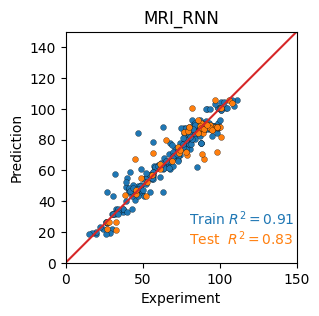

In [ ]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2)

plt.xlabel("Experiment")#,fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction")#,fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
#plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'})#, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_RNN')#,fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_RNN.pdf", dpi=1200, bbox_inches='tight')